In [7]:
from dotenv import load_dotenv
import os

# Load environment variables from a .env file
load_dotenv()

# Set the GROQ_API_KEY from the loaded environment variables
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

# Check if the API key is available
if not os.environ.get("GROQ_API_KEY"):
    raise ValueError("GROQ_API_KEY not found. Please set it in your .env file.")


In [12]:
from typing import TypedDict, Annotated, List, Dict, Optional
from langchain_community.tools import DuckDuckGoSearchRun

# Initialize the search tool for our agents
search_tool = DuckDuckGoSearchRun()

# Define the new state for our dynamic graph
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        research_topic: The initial topic for the market research.
        research_plan: A dictionary where keys are the names of agents to be called.
        # Specialist agent results are now Optional, as they may not be called.
        financial_analysis: Optional[str]
        product_analysis: Optional[str]
        sentiment_analysis: Optional[str]
        final_report: str
    """
    research_topic: str
    research_plan: Dict[str, str]
    financial_analysis: Optional[str]
    product_analysis: Optional[str]
    sentiment_analysis: Optional[str]
    final_report: str


In [13]:
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage
import json

# Initialize the LLM for all agents
llm = ChatGroq(model="llama3-70b-8192", temperature=0)

def orchestrator_agent(state: GraphState):
    """
    The project manager agent. It analyzes the topic and creates a dynamic plan,
    delegating tasks ONLY to the necessary specialist agents.
    """
    print("--- NODE: Orchestrator Agent ---")
    topic = state['research_topic']
    
    system_prompt = SystemMessage(content="""
    You are a master market research strategist. Your job is to analyze a research topic
    and decide which specialist agents are needed to complete the task.

    The available specialist agents are:
    1.  `financial_agent`: Use for topics involving market size, investments, financial trends, or business numbers.
    2.  `product_agent`: Use for topics involving competitor products, features, pricing, or technical specifications.
    3.  `sentiment_agent`: Use for topics involving public opinion, news analysis, social media trends, or brand perception.

    Based on the topic, create a dictionary where keys are the names of the agents that are
    ABSOLUTELY NECESSARY and values are their specific research tasks.
    
    For example, if the topic is "Financial viability of a new coffee shop in London", you would only need the financial_agent.
    If the topic is "Public sentiment on the new iPhone vs. Samsung", you might only need the sentiment_agent and product_agent.

    Do NOT include agents that are not relevant. Output ONLY the JSON object representing this dynamic plan.
    """)
    
    task_prompt = HumanMessage(
        content=f"Analyze the following research topic and create a dynamic, delegated research plan: '{topic}'."
    )
    
    response = llm.invoke([system_prompt, task_prompt])
    plan = json.loads(response.content)
    
    print(f"✅ Orchestrator created a dynamic plan calling {list(plan.keys())} agents.")
    return {"research_plan": plan}

def research_agent_node(state: GraphState, agent_name: str):
    """
    A generic research node that executes a task for a given specialist agent.
    """
    print(f"--- NODE: Specialist Agent ({agent_name}) ---")
    plan = state['research_plan']
    
    research_task = plan.get(agent_name)
    if not research_task:
        return {f"{agent_name}_analysis": "No task assigned."}

    print(f"Executing task: {research_task}")
    search_results = search_tool.run(research_task)
    
    system_prompt = SystemMessage(content=f"""
    You are a specialized research analyst: a {agent_name}. Your task is to analyze
    the provided search results and write a concise summary that directly answers
    your assigned research question.
    """)
    
    task_prompt = HumanMessage(
        content=f"Research Question: {research_task}\n\nSearch Results:\n{search_results}"
    )
    
    response = llm.invoke([system_prompt, task_prompt])
    
    return {f"{agent_name}_analysis": response.content}

def synthesizer_agent(state: GraphState):
    """
    The lead author agent. It writes the final report from the available research.
    It is robust to missing data from agents that were not called.
    """
    print("--- NODE: Synthesizer Agent ---")
    topic = state['research_topic']
    
    # Use .get() to safely access results, providing a default message if an agent wasn't run.
    financial_analysis = state.get('financial_analysis', 'Not analyzed.')
    product_analysis = state.get('product_analysis', 'Not analyzed.')
    sentiment_analysis = state.get('sentiment_analysis', 'Not analyzed.')
    
    consolidated_research = f"""
    Financial Analysis:
    {financial_analysis}

    ---
    Product and Competitor Analysis:
    {product_analysis}

    ---
    Public Sentiment Analysis:
    {sentiment_analysis}
    """
    
    system_prompt = SystemMessage(content="""
    You are a senior market analyst. Your task is to write a comprehensive market
    research report based on the provided data from your specialist teams. If a section
    was 'Not analyzed,' briefly state that in the report. The report must be well-structured,
    insightful, and professionally formatted using markdown.
    """)
    
    task_prompt = HumanMessage(
        content=f"""
        Please write a full market research report on the topic: '{topic}'.
        
        Use the following consolidated research findings:
        {consolidated_research}
        """
    )
    
    response = llm.invoke([system_prompt, task_prompt])
    print("✅ Final report synthesized.")
    return {"final_report": response.content}


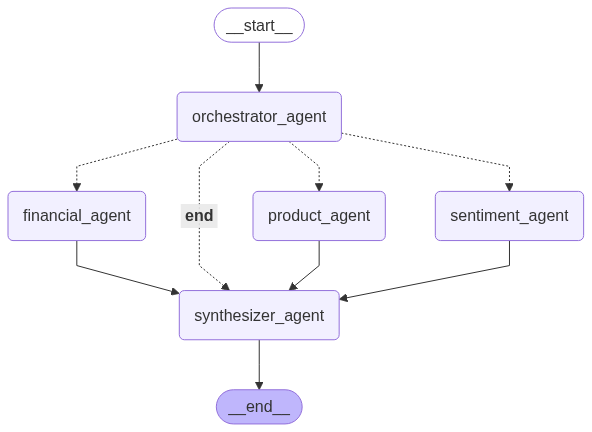

In [14]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from functools import partial

def route_to_specialists(state: GraphState):
    """
    This function acts as a router. It reads the research plan and returns
    a list of the agent names that need to be called.
    """
    print("--- CONDITIONAL EDGE: Routing to specialists ---")
    plan = state.get("research_plan", {})
    # The list of node names to run next
    agents_to_run = list(plan.keys())
    print(f"Decision: The following agents will run in parallel: {agents_to_run}")
    return agents_to_run

# Initialize a new state graph
workflow = StateGraph(GraphState)

# Add all possible nodes to the graph
workflow.add_node("orchestrator_agent", orchestrator_agent)
workflow.add_node("synthesizer_agent", synthesizer_agent)
workflow.add_node("financial_agent", partial(research_agent_node, agent_name="financial"))
workflow.add_node("product_agent", partial(research_agent_node, agent_name="product"))
workflow.add_node("sentiment_agent", partial(research_agent_node, agent_name="sentiment"))

# The entry point is the orchestrator
workflow.set_entry_point("orchestrator_agent")

# Use conditional routing after the orchestrator
# This will "fan-out" to only the agents specified in the plan
workflow.add_conditional_edges(
    "orchestrator_agent",
    route_to_specialists,
    {
        # The keys of this dictionary are the possible outputs of our router function.
        # The values are the names of the nodes to go to.
        "financial_agent": "financial_agent",
        "product_agent": "product_agent",
        "sentiment_agent": "sentiment_agent",
        # A special "__end__" key is used for cases where the router returns an empty list
        # (though our current setup won't do this, it's good practice).
        # We route to the synthesizer if no specialists are needed.
        "__end__": "synthesizer_agent" 
    }
)

# Define the "fan-in" point. All specialist agents, once they finish,
# will pass their results to the synthesizer agent. LangGraph automatically
# waits for all active parallel branches to complete.
workflow.add_edge("financial_agent", "synthesizer_agent")
workflow.add_edge("product_agent", "synthesizer_agent")
workflow.add_edge("sentiment_agent", "synthesizer_agent")

# The synthesizer is the final step before the end
workflow.add_edge("synthesizer_agent", END)

# Compile the graph
app = workflow.compile()

# Display the graph structure
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}. Please ensure pygraphviz and its dependencies are installed.")


In [ ]:
def print_boxed(title, content):
    """Helper function to print content in a formatted box."""
    box_width = 100
    print("\n" + "╔" + "═" * (box_width - 2) + "╗")
    title_line = f"║ 📄 {title.upper()} "
    print(title_line + " " * (box_width - len(title_line) - 1) + "║")
    print("╠" + "═" * (box_width - 2) + "╣")
    
    lines = content.split('\n')
    for line in lines:
        temp_line = line
        while len(temp_line) > box_width - 4:
            split_pos = temp_line.rfind(' ', 0, box_width - 4)
            if split_pos == -1:
                split_pos = box_width - 4
            print(f"║ {temp_line[:split_pos]:<{box_width - 4}} ║")
            temp_line = temp_line[split_pos:].lstrip()
        print(f"║ {temp_line:<{box_width - 4}} ║")

    print("╚" + "═" * (box_width - 2) + "╝" + "\n")

# Get the initial topic from the user
topic = input("Hello! What is the topic for your market research report? ").strip()

# Set the recursion limit for the graph execution
config = {"recursion_limit": 150}

# Prepare the initial state
initial_state = {"research_topic": topic}

# Stream the graph execution and print updates
final_state = None
for event in app.stream(initial_state, config=config):
    for node_name, state_update in event.items():
        print(f"\n--- Event: Finished '{node_name}' ---")
    final_state = list(event.values())[-1]

print("\n" + "🎉"*20)
print("Market Research Report Generation Complete!")
print("🎉"*20 + "\n")

# Print the final, synthesized report in a formatted box
if final_state and final_state.get("final_report"):
    print_boxed("Final Market Research Report", final_state['final_report'])
else:
    print("The process did not result in a final report.")
